# Hartree-Fock approximation for $A$ spinless fermions in a HO trap and an inter-particle Gaussian potential

## Spinless particles in a HO trap
We study a system of $A$ identical fermions with mass $m$ trapped in a harmonic trap 
of frequency $\omega$. We neglect spin in the following, assuming that the system is fully polarized. 
We focus on a finite-range gaussian inter-particle interaction, which yields the following Hamiltonian in real space:
\begin{align}
\hat H =& - \frac{\hbar^2}{2m} \sum_{i=1}^A  \nabla_i^2 + \frac{1}{2} m \omega^2 \sum_{i=1}^A  x_i^2 
+ 
\frac{V}{\sqrt{ 2 \pi} \sigma} \sum_{i<j}  e^{ - \frac{ (x_i-x_j )^2}{2 \sigma^2} } \, .
\label{eq:hamiltonian2}
\end{align}
The gaussian interaction is characterised by an interaction strength, $V$, and an interaction range, $\sigma$.
We choose these so that, in the limit $\sigma \to 0$ the potential becomes a contact interaction, $\to V \delta( x_i - x_j )$.

We use harmonic oscillator (HO) units throughout the remainder of this work:
lengths are defined in terms of $a_\text{ho} = \sqrt{ \frac{\hbar}{ m \omega} }$ and energies are measured in units of $\hbar \omega$. 
The Hamiltonian becomes
\begin{align}
\hat H =& - \frac{1}{2} \sum_{i=1}^A  \nabla_i^2 + \frac{1}{2} \sum_{i=1}^A  x_i^2  + 
\frac{V_0}{\sqrt{ 2 \pi} \sigma_0} \sum_{i<j}  e^{ - \frac{ (x_i-x_j )^2}{2 \sigma_0^2} } .
\label{eq:hamiltonian}
\end{align}
The interaction range is redefined, so that
$
\sigma_0 =  \sigma / a_\text{ho} \, .
$
The dimensionless interaction strength $V_0$ is related to the dimensionfull constant $V$ by
$
V_0 = V / (a_\text{ho} \hbar \omega ).
$

## Hartree-Fock approximation
The HF orbitals $\phi_\alpha(x)$ with 
$\alpha=0, \ldots, A-1$ are fully occupied, with 
occupation numbers $n_\alpha=1$. 
All the remaining states with $\alpha \geq A$ are empty,
$n_\alpha=0$.
The HF orbitals are used to construct a one-body density matrix,
\begin{align}
\rho^{\text{HF}}(x_1',x_1) = \sum_{\alpha=1}^A \phi^*_\alpha(x_1') \phi_\alpha(x_1),
\label{eq:OBDM_HF}
\end{align}
and the corresponding density profile $n^{\text{HF}}(x)=\rho^{\text{HF}}(x_1=x,x_1'=x)$.
The orbitals are obtained from the HF equations, 
\begin{align}
\left[ - \frac{1}{2} \nabla^2 + \frac{1}{2} x^2 \right] \phi_\alpha(x)
+ \int d \bar x \Sigma(x,\bar x) \phi_\alpha(\bar x)
= \varepsilon^{\text{HF}}_\alpha \phi_\alpha(x) \, .
\label{eq:HF}
\end{align}
In the case of a finite-range interaction, the HF equations are a set of $A$ 
integro-differential equations. The HF self-energy is the sum of a
direct and a (non-local) exchange term,
\begin{align}
\Sigma(x_1',x_1) =& \delta( x_1 - x_1' ) \int d x \, V( x_1-x) n^{\text{HF}}(x) + V(x_1'-x_1) \rho^{\text{HF}}(x_1',x_1) \, .
\label{eq:HF_meanfield}
\end{align}
The corresponding HF energy is computed from the sum of single-particle energies
and, as a consistency check, it can also be obtained from the direct integral of the mean-field, with 
the associated antisymmetry corrections.

<!-- We solve this set of self-consistent equations by iteration on a discretised mesh  of equidistant points.  
The kinetic term is represented as a matrix using the Fourier grid Hamiltonian method~\cite{Marston89}, which works so long as the mesh extends well beyond the support of the wavefunctions. The mean-field can be computed efficiently with matrix
operations, and Eq.~(\ref{eq:HF}) is reduced to an eigenvalue problem. 
We typically employ $N=200$  grid points extending from $x=-5$ to $5$ for
small systems. For systems with $A>4$, which have larger sizes, the mesh 
limits are extended to $\pm 6$ and we choose $N=240$ points to keep the same mesh spacing.
-->

## Numerical solution of the problem
The code below attempts to solve the problem. We describe it succinctly. We start by calling in routines.

In [1]:
# coding: utf-8
##########################################################################
# THIS PYTHON CODE SOLVES THE TWO-BODY PROBLEM IN 1D
# 2 PARTICLES IN A HO TRAP WITH A GAUSSIAN INTERACTION
##########################################################################
import sys
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import math
import scipy
from scipy import interpolate

import os

from harmonic_oscillator import *

We now define mathematical constants. Then we proceed to produce vectors that define the gaussian interaction strength, $V$, called V_strength, and range, $\sigma_0$, called s_range. We also define the total number of eigenvalues and eigenvectors to be solved for each hamiltonian. 

In [18]:
##########################################################################
pi=math.pi
zi=complex(0.,1.)

eps_system=sys.float_info.epsilon
zero_low=eps_system*1000

# NUMBER OF PARTICLES
A_num_part=6
Astr=str(A_num_part)
print(Astr)

# DEFINES THE VALUES OF INTERACTION STRENGTH AND INTERACTION RANGE
#nV=41
nV=1
nS=1
V_strength=np.linspace(-10,-10,nV)
S_range=np.linspace(0.5,0.5,nS)
VV,ss=np.meshgrid(V_strength,S_range)


6


We now define the uniform mesh in real space in which we solve the equations. This goes from $x_0=-L+\delta x$ to $x_{N_x-1}=L$ in $N_x$ points. The variables for $L$ and $N_x$ are `xL` and `Nx` respectively. Because we use the Fourier grid hamiltonian method, we also introduce a momentum space mesh.

Using the Fourier grid method, we can now compute a representation of the discretized second derivative matrix. This approximates accurately the operartor $\partial_r^2$ into a matrix which we store into variable der2. 

In [19]:
# REAL-SPACE MESH DIMENSION AND NUMBER POINTS
# REAL-SPACE MESH DIMENSION AND NUMBER POINTS
if( A_num_part < 5 ) :
    xL=5.
    Nx=200
else :
    xL=6.
    Nx=240
    
# GRID SPACING
delx=2*xL/Nx

# MESH IN X-SPACE - FROM -xL+del x UP TO +xL
xx=np.zeros(Nx)
#xx=np.arange(-xL+delx,xL,delx);
#print(xx)
xx=delx*(np.arange(Nx)-Nx/2.)
indx_origin=int(Nx/2)
[x1,x2]=np.meshgrid(xx,xx)

# SPACING IN MOMENTUM SPACE
delp=2.*pi/(2.*xL)

# MESH IN p SPACE
pp=np.zeros(Nx)
#pp=delp*(np.arange(Nx)-Nx/2.)
#print(pp)
for i in range(0,Nx) :
    pp[i]=(i-Nx/2)*delp

# SECOND DERIVATIVE MATRIX
cder2=np.zeros((Nx,Nx),complex)
der2=np.zeros((Nx,Nx))
# LOOP OVER I AND J
for i, xi in enumerate( xx ) :
    for j, xj in enumerate( xx ) :
        cder2[i,j] = np.dot( np.exp( zi*(xj-xi)*pp ), np.power(pp,2) )
        #cder2[i,j] = np.dot( np.cos( (xj-xi)*pp )+zi*np.sin( (xj-xi)*pp ), np.power(pp,2) )

# ADD PHYSICAL FACTORS AND KEEP REAL PART ONLY FOR SECOND DERIVATIVE
der2=-np.real(cder2)*delx*delp/2./pi
kin_mat=-der2/2. # COULD ADD HBAR2/M HERE IF OTHER UNITS USED

We now create a series of folders to store the generated data and figures for different values of $V$, $\sigma$, $N_x$ and $L$. We also declare several arrays. For instance, we create an array of size $N_x$ for the harmonic oscillator external potential (`V_HO`). 

In [20]:
folder_numerics="xL" + str(xL) + "_Nx" + str(Nx)

######################################################
# CREATE DATA/PLOT DIRECTORY IF THEY DO NOT EXIST
# PREPARE DATA AND PLOT FOLDERS
datafolder="data"
plotfolder="plots"
if not os.path.exists(datafolder):
    os.makedirs(datafolder)

if not os.path.exists(plotfolder):
    os.makedirs(plotfolder)

if not os.path.exists("data/" + folder_numerics):
    os.makedirs("data/" + folder_numerics)
data_folder="data/" + folder_numerics + "/"

if not os.path.exists("plots/" + folder_numerics):
    os.makedirs("plots/" + folder_numerics)
plot_folder="plots/" + folder_numerics + "/"
######################################################

# HARMONIC OSCILLATOR MATRIX IN REAL SPACE - DIAGONAL
U_HO=np.power(xx,2.)/2.

# HARTREE-FOCK POTENTIAL
accu=1e-9
itermax=20000
pfac=1./np.abs( np.amax(kin_mat) )
ffac=0.4

# PREPARE ARRAYS
hf_den=np.zeros(Nx)
denf=np.zeros(Nx)
Uex=np.zeros(Nx)
hf_den_mat=np.zeros((Nx,Nx))
H = np.zeros((Nx,Nx))

# INITIALIZE ARRAYS
# NOTE Nmax IS USED AS MAXIMUM IN PYTHON RANGE ARRAYS, SO IT IS ACTUALLY A-1 IN MATHS TERMS
Nmax=A_num_part
wfy=np.zeros((Nx,Nmax))
spe=np.zeros(Nmax)
for ieig in range(Nmax) :
    wfy[:,ieig] = wfho(ieig,xx)

# DEFINE MATRICES AS A FUNCTION OF S AND V
energy=np.zeros((5,nV,nS))
A_num_sum=np.zeros((nV,nS))
rms_den=np.zeros((nV,nS))

We now open loops over the range and the strength of the interaction. We store the Gaussian interaction into an array `V_Gauss` and add it up to the Harmonic Oscillator. We create an $N_x \times N_x$ matrix `V` which contains the interaction of the system. 

We then start an iterative procedure to solve the Hartree-Fock equations. We use the Rayleigh method to estimate the HF eigenvalues at each iteration. 

The data is saved in the ``data`` folders. We also plot the relative wavefunction, the density profile and the density matrix.


s_range=0.5 V0= -10.0
# ITER  NUM_PART      X_CM         EHF          EHF2         EKIN         EPOT         ESUM         DIFFS
  50 6.000287E+00 2.631635E+00 6.483346E+00 6.472236E+00 1.031183E+01 -1.559669E+01 -5.262640E+00 3.282540E-02
 100 6.000218E+00 2.339501E+00 5.521193E+00 5.513068E+00 1.162449E+01 -1.925785E+01 -7.617111E+00 2.930116E-02
 150 6.000167E+00 2.112828E+00 4.824588E+00 4.818790E+00 1.288800E+01 -2.248867E+01 -9.589078E+00 2.582916E-02
 200 6.000127E+00 1.938219E+00 4.332193E+00 4.328152E+00 1.405955E+01 -2.528566E+01 -1.121803E+01 2.257593E-02
 250 6.000094E+00 1.803948E+00 3.992030E+00 3.989278E+00 1.511352E+01 -2.766592E+01 -1.254690E+01 1.944904E-02
 300 6.000068E+00 1.700680E+00 3.762054E+00 3.760218E+00 1.603735E+01 -2.966004E+01 -1.361901E+01 1.648622E-02
 350 6.000047E+00 1.621179E+00 3.609567E+00 3.608365E+00 1.682915E+01 -3.130756E+01 -1.447600E+01 1.379473E-02
 400 6.000032E+00 1.559887E+00 3.510118E+00 3.509344E+00 1.749507E+01 -3.265268E+01 -1.515607E

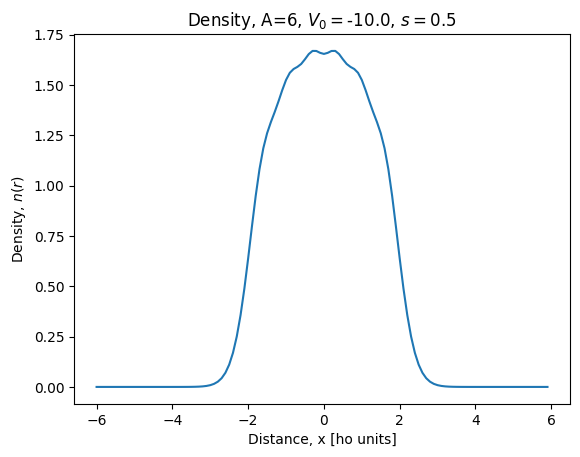

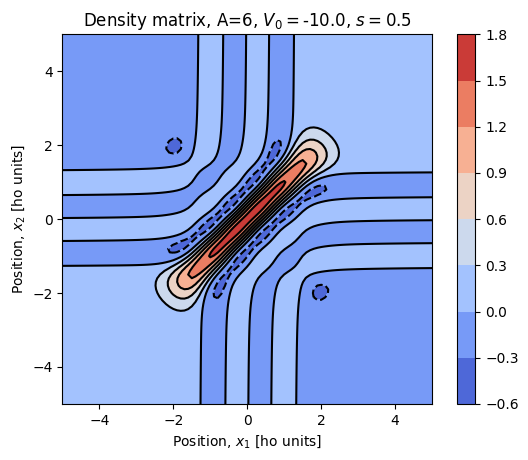

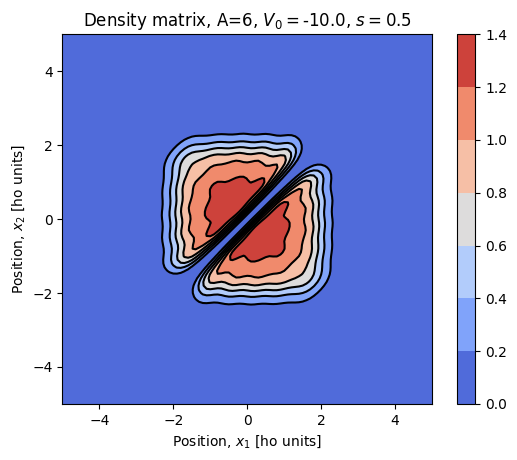

In [21]:
header_screen="# ITER".ljust(8)+"NUM_PART".ljust(14) + "X_CM".ljust(13) + "EHF".ljust(13) + "EHF2".ljust(13) + "EKIN".ljust(13) + "EPOT".ljust(13) + "ESUM".ljust(13) + "DIFFS"

# LOOP OVER INTERACTION RANGE
for iS,s in enumerate( S_range ) :
    s_string="{:.1f}".format(s)
# LOOP OVER INTERACTION STRENGTH
    for iV,V0 in enumerate( V_strength ) :
        V0string="{:.1f}".format(V0)
        print("\ns_range=" + s_string + " V0=",V0string)
        print(header_screen)

        # INTERACTION POTENTIAL MATRIX
        Vint=V0/np.sqrt(2.*pi)/s*np.exp( -np.power(x1-x2,2)/2./np.power(s,2) )

        # START HARTREE-FOCK ITERATION PROCEDURE
        iter=0
        diffs=10.
        while ( diffs > accu and iter<itermax ) :
            iter=iter+1
            # ... PREPARE DENSITY AND DENSITY MATRIX FROM ORBITALS
            hf_den=0.
            hf_den_mat=0.
            for ieig in range(Nmax) :
                hf_den=hf_den+ np.power( abs( wfy[:,ieig] ), 2)
                hf_den_mat=hf_den_mat + np.outer( wfy[:,ieig], wfy[:,ieig] )

            # COMPUTE DENSITY 
            denf=hf_den
            
            # COMPUTE PAIR DISTRIBUTION FUNCTION
            pair_dist=( np.outer( denf,denf ) - hf_den_mat*hf_den_mat.T )/2
            
            # MEAN-FIELD - DIRECT TERM
            Udir = delx*np.matmul(Vint,denf)
            
            # MEAN-FIELD - DIRECT TERM
            Umf_mat = -delx*Vint*hf_den_mat

            Uexc = np.diagonal(Umf_mat).copy()

            # ADD ALL MEAN-FIELD TERMS TOGETHER
            np.fill_diagonal( Umf_mat, Umf_mat.diagonal() + Udir + U_HO)
            # MEAN-FIELD ALONG DIAGONAL
            Umf = np.diagonal(Umf_mat).copy()

            # HAMILTONIAN Nx x Nx MATRIX
            H=kin_mat + Umf_mat

            #cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc
            # ... USE RAYLEIGH APPROXIMATION TO FIND APPROXIMATE EIGENVALUES
            # ... LOOP OVER EIGENVALUES
            diffs=0.
            ekin0hf=0.
            epot0hf=0.
            for ieig in range(Nmax) :
            # ... GUESS EIGENVALUE WITH RAYLEIGH METHOD
                wf0=wfy[:,ieig]
                wff=np.matmul( H, wf0 )
                spe[ieig]=np.real( np.dot( wf0 , wff) )*delx

            # GRADIENT ITERATION
                wfb=wf0 - wff*pfac
                norm=math.fsum( np.power( np.abs(wfb),2 ))*delx
                wff=wfb/np.sqrt(norm)
                #print(wff[99])

            # ... ORTHOGONALIZATION
                wfo=0.
                for jeig in range(0,ieig) :
                    wfo = wfo + wfy[:,jeig]*np.dot( wfy[:,jeig],wff )*delx
                wff=wff-wfo
                norm=math.fsum( np.power( np.abs(wff),2 ))*delx
                wff=wff/norm

                # ... vec_k+1 = (A-mI)^-1 * vec_k
                diffs=diffs + np.amax( abs(wf0 - wff) )
                wfy[:,ieig] = ffac*wff + (1.-ffac)*wf0

                if( ieig <= Nmax ) :
                    ekin0hf=ekin0hf + np.real( np.dot( wfy[:,ieig], np.matmul( kin_mat,wfy[:,ieig])) )*delx
                    epot0hf=epot0hf + np.real( np.dot( wfy[:,ieig], np.matmul( Umf_mat,wfy[:,ieig])) )*delx

            esum0hf=np.sum(spe[0:Nmax])

            # HARTREE-FOCK DENSITY IS USED TO COMPUTE AVERAGE POSITION xa AND RMS x2_av
            xa=np.sum( hf_den )*delx
            x2_av=delx*np.dot( hf_den,np.power(xx,2) )/ (delx*np.sum( hf_den ))

            # ENERGY FROM GMK SUMRULE
            eho=np.sum( hf_den*U_HO ) *delx/2.
            enerhfp=(esum0hf+ekin0hf)/2.+eho

            # ENERGY FROM INTEGRAL (DF)
            epothf=epot0hf-2.*eho
            enerhf=esum0hf-epothf/2.

            # PRINT DATA TO SCREEN
            formatd=["%12.6E"] * 8
            formatd=["%4i"] + formatd
            if iter%50 == 0 :
                ddd=np.vstack([iter,xa,x2_av,enerhf,enerhfp,ekin0hf, epot0hf,esum0hf,diffs])
                data_to_write =np.column_stack( ddd )
                np.savetxt(sys.stdout,ddd.T,fmt=formatd)

        # ITERATION LOOP IS OVER - PRINT FINAL RESULTS
        energy[0,iV,iS]=enerhf
        energy[1,iV,iS]=enerhfp
        energy[2,iV,iS]=ekin0hf
        energy[3,iV,iS]=eho
        energy[4,iV,iS]=epothf

        A_num_sum[iV,iS]=xa
        rms_den[iV,iS]= x2_av

        ##############################################################################
        # PLOTS OF DENSITY
        if( nS == 1) :
            plot_filedd=plot_folder + "density_" + Astr + "_particles_V0=" + V0string + ".pdf"
        elif( nV==1 ) :
            plot_filedd=plot_folder + "density_" + Astr + "_particles_s=" + s_string + ".pdf"
        else :
            plot_filedd=plot_folder + "density_" + Astr + "_particles_V0=" + V0string + "_s=" + s_string + ".pdf"

        if os.path.exists( plot_filedd ) :
            os.remove(plot_filedd)

        plt.xlabel("Distance, x [ho units]")
        plt.ylabel("Density, $n(r)$")
        plt.title("Density, A=" + Astr + ", $V_0=$" + V0string + ", $s=$" + str(s) )
        plt.plot(xx,denf)
        plt.show()
        plt.savefig(plot_filedd)
        plt.close()


        ##############################################################################
        # PLOTS OF DENSITY MATRIX
        if( nS == 1) :
            plot_filedm=plot_folder + "denmat_" + Astr + "_particles_V0=" + V0string + ".pdf"
        elif( nV==1 ) :
            plot_filedm=plot_folder + "denmat_" + Astr + "_particles_s=" + s_string + ".pdf"
        else :
            plot_filedm=plot_folder + "denmat_" + Astr + "_particles_V0=" + V0string + "_s=" + s_string + ".pdf"

        if os.path.exists( plot_filedm ) :
            os.remove(plot_filedm)

        fig, ax = plt.subplots()
        fcont=ax.contourf(xx,xx,hf_den_mat,cmap='coolwarm')
        ax.contour(xx,xx,hf_den_mat, colors='k')
        ax.axis("square")
        fig.colorbar(fcont,ax=ax)
        ax.set_xlabel("Position, $x_1$ [ho units]")
        ax.set_ylabel("Position, $x_2$ [ho units]")
        ax.set_title("Density matrix, A=" + Astr + ", $V_0=$" + V0string + ", $s=$" + str(s) )
        ax.set_xlim([-5,5])
        ax.set_ylim([-5,5])
        plt.savefig(plot_filedm)
        plt.show()
        plt.close(fig)

        ##############################################################################
        # PLOTS OF PAIR DISTRIBUTION
        if( nS == 1) :
            plot_filedm=plot_folder + "pairdist_" + Astr + "_particles_V0=" + V0string + ".pdf"
        elif( nV==1 ) :
            plot_filedm=plot_folder + "pairdist_" + Astr + "_particles_s=" + s_string + ".pdf"
        else :
            plot_filedm=plot_folder + "pairdist_" + Astr + "_particles_V0=" + V0string + "_s=" + s_string + ".pdf"

        if os.path.exists( plot_filedm ) :
            os.remove(plot_filedm)

        fig, ax = plt.subplots()
        fcont=ax.contourf(xx,xx,pair_dist,cmap='coolwarm')
        ax.contour(xx,xx,pair_dist, colors='k')
        ax.axis("square")
        fig.colorbar(fcont,ax=ax)
        ax.set_xlabel("Position, $x_1$ [ho units]")
        ax.set_ylabel("Position, $x_2$ [ho units]")
        ax.set_title("Density matrix, A=" + Astr + ", $V_0=$" + V0string + ", $s=$" + str(s) )
        ax.set_xlim([-5,5])
        ax.set_ylim([-5,5])
        plt.savefig(plot_filedm)
        plt.show()
        plt.close(fig)

